In [39]:
import scipy.integrate
import numpy
import matplotlib.pyplot
import os
import json
import scipy.interpolate
#for partial specialization
import cModel
import importlib
importlib.reload(cModel)
import time
import ivp
importlib.reload(ivp)
import runSolver
importlib.reload(runSolver)

def getModel(data,modelName):
    Q=data[modelName]['solution']
    model=cModel.model()
    setupFile=Q['setup']
    modelFile=Q['model']
    parameterFile=Q['parameters']
    print('modelFile: {} {}'.format(modelFile,os.path.isfile(modelFile)))
    print('parameterFile: {} {}'.format(parameterFile,os.path.isfile(parameterFile)))
    model.parse(modelFile,parameterFile)
    return model

def getSum(data,modelName):
    
    model=getModel(data,modelName)
    Q=data[modelName]['solution']
    lut=Q['lut']
    total=Q['sol'][-1,lut['total']]
    #print(total)
    fQ={}
    for x in lut:
        if x=='total':
            continue
        j=lut[x]
        try:
            v=model.get(model.mod['volumes'][x])['value']
            fQ[x]=Q['sol'][-1,j]*v/total
        except KeyError:
            #print('{} {}'.format(x,x in model.mod['scaled']))
            fQ[x]=Q['sol'][-1,j]
    print(sum(list(fQ.values())))
    print(sorted(fQ.items(), key=lambda item:item[1]))
    

In [ ]:
#run solver
fh=os.path.expanduser('~')
i=0
data={}
a={}
#based on
#Evaluation of the Uncertainty in an Oral Reference Dose
#for Methylmercury Due to Interindividual Variability in
#Pharmacokinetics
a['jobDir']=os.path.join(fh,'temp','humanHG_RBC')
a['modelFile']=os.path.join(fh,'software','src','PBPK','models','humanHG_RBC.json')
a['parameterFile']=os.path.join(fh,'software','src','PBPK','models','humanHG_RBC_parameters.json')
a['doCalculate']=False
data['humanHG_RBC']=a
b={}
#based on
#A Toxicokinetic Model for Predicting the Tissue Distribution and Elimination of Organic and 
#Inorganic Mercury Following Exposure to Methyl Mercury in Animals and Humans. 
#II. Application and Validation of the Model in Humans
b['jobDir']=os.path.join(fh,'temp','humanHGplusI_RBC')
b['modelFile']=os.path.join(fh,'software','src','PBPK','models','humanHGplusI_RBC.json')
b['parameterFile']=os.path.join(fh,'software','src','PBPK','models','humanHGplusI_RBC_parameters.json')
b['doCalculate']=False
data['humanHGplusI_RBC']=b
c={}
c['jobDir']=os.path.join(fh,'temp','humanHG')
c['modelFile']=os.path.join(fh,'software','src','PBPK','models','humanHG.json')
c['parameterFile']=os.path.join(fh,'software','src','PBPK','models','humanHG_parameters1.json')
c['doCalculate']=False
data['humanHG']=c
d={}
d['jobDir']=os.path.join(fh,'temp','humanHGplusI')
d['modelFile']=os.path.join(fh,'software','src','PBPK','models','humanHGplusI.json')
d['parameterFile']=os.path.join(fh,'software','src','PBPK','models','humanHGplusI_parameters.json')
d['doCalculate']=True
data['humanHGplusI']=d
#select=setups['humanHGplusI']
#select=setups['humanHGplusI']

for x in data:
    print('{} {} {}'.format(i,x,data[x]['jobDir']))
    select=data[x]
    if i==1:
        srcDir=select['jobDir']
    if i>1:
        srcDir=select['jobDir']+'{}'.format(i-1)

    if i>0: 
        select['jobDir']=select['jobDir']+'{}'.format(i)
    
    print('{}'.format(data[x]['jobDir']))
    
    if not os.path.isdir(select['jobDir']):
        os.mkdir(select['jobDir'])

    setupFileSrc=os.path.join(fh,'software','src','PBPK','setup','setupDay.json')
    setupFile=os.path.join(select['jobDir'],'setupDay.json')

    with open(setupFileSrc,'r') as f:
        setup=json.load(f)
    setup['tmax']=i+1
    with open(setupFile,'w+') as f:
        f.write(json.dumps(setup))
        
    if not select['doCalculate']:
        continue
    if i>0:
        runSolver.main([setupFile,select['modelFile'],select['parameterFile']],select['jobDir'],srcDir)
    if i==0:
        runSolver.main([setupFile,select['modelFile'],select['parameterFile']],select['jobDir'])


#t0,y0,S1,lut,lutSE=runSolver.getStartPoint(setup)


In [ ]:

for x in data:
    data[x]['solution']=runSolver.loadSolutionFromDir(data[x]['jobDir'],True)


In [31]:
importlib.reload(cModel)
importlib.reload(ivp)
importlib.reload(runSolver)

model=getModel(data,'humanHG')

#model.inspect()
model.Su(3)[model.lutSE['intestineVolumeFraction'],model.lut['intestine']]
print(model.lut)



modelFile: /home/studen/temp/humanHG/model.json True
parameterFile: /home/studen/temp/humanHG/parameters.json True
{'redBloodCells': 0, 'plasma': 1, 'venous': 2, 'kidney': 3, 'urine': 4, 'richlyPerfused': 5, 'fat': 6, 'slowlyPerfused': 7, 'hair': 8, 'brainBlood': 9, 'brain': 10, 'liver': 11, 'gut': 12, 'intestine': 13, 'feces': 14, 'inorganicMercury': 15, 'total': 16}


In [ ]:
model=getModel(data,'humanHG')
tscale=runSolver.getScale(data['humanHG']['solution']['setup'])

model.inspect()    

print("***********done************")
print(model.M(1).shape)
#print(sys.fSS(2))
print(model.m)

nt=setup['nt']
qtmax=24*60*365*10
qt=numpy.linspace(0,qtmax,nt)
#ft=[fw['derivatives']['fetusGrowthDuration'](x) for x in qt]
try:
    fw=model.get('fetusWeight')
    ft=[fw['value'](x) for x in qt]
    matplotlib.pyplot.plot(qt/tscale,ft)
except (KeyError,TypeError):
    pass

try:
    hw=model.get('hairVolume')
    ht=[10*hw['value'](x) for x in qt]
    matplotlib.pyplot.plot(qt/tscale,ht)
except (KeyError,TypeError):
    pass
start_time=time.time()
for i in range(100000):
    model.M(1e7)
end_time=time.time()
print('Time: {:.3f} s'.format(end_time-start_time))
print(model.M(1000)[8,:])

modelFile: /home/studen/temp/humanHGplusI_RBC/model.json True
parameterFile: /home/studen/temp/humanHGplusI_RBC/parameters.json True


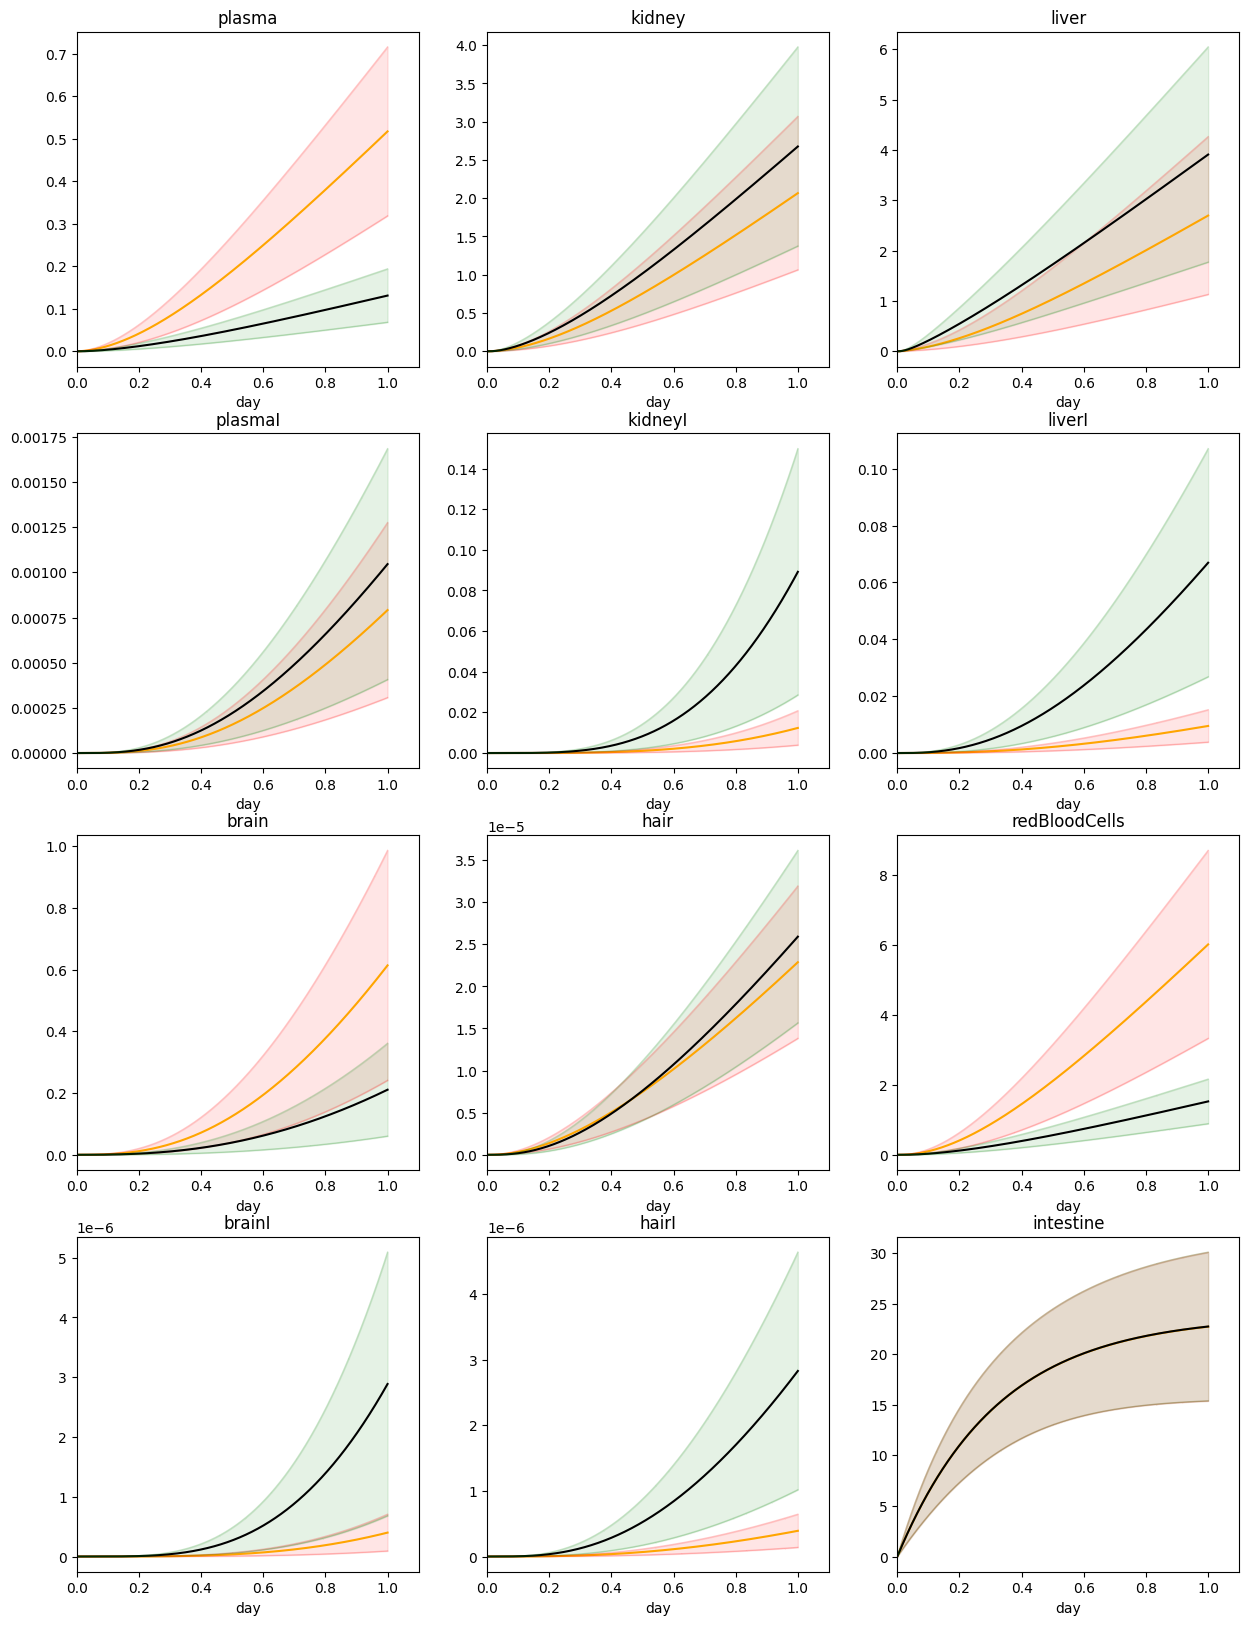

In [41]:
i=0
model=getModel(data,'humanHGplusI_RBC')
tscale=runSolver.getScale(data['humanHGplusI_RBC']['solution']['setup'])
model.get("bloodToPlasmaPCscale")
#for x in data:
#    data[x]['model']=getModel(data,x)

name=['plasma','kidney','liver',
      'plasmaI','kidneyI','liverI',
      'brain','hair','redBloodCells',
      #'brainBlood','inorganicMercury','total'
     'brainI','hairI','intestine'
      ]
tmax=data['humanHG_RBC']['solution']['t'][-1]
alias={'plasmaI':'bloodI'}
max=[-1]*len(name)
#max[2]=2000
models={}
models['humanHGplusI']={'color':'orange','shadeColor':'red'}
models['humanHGplusI_RBC']={'color':'black','shadeColor':'green'}

fig, axs = matplotlib.pyplot.subplots(4, 3,figsize=(15,20))
for i in range(len(name)):
    row=i//3
    col=i%3
    ax=axs[row,col]
    for m in models:
        fM=models[m]
        Q=data[m]['solution']
        v=name[i]
        try:
            j=Q['lut'][v]
        except KeyError:
            try:
                v1=alias[v]
            except KeyError:
                print('No data for {}'.format(v))
                continue    
            try:
                j=Q['lut'][v1]
            except KeyError:
                print('No data for {}/{}'.format(v,v1))
                continue    
                
        fy=Q['sol'][:,j]
        fe=Q['se'][:,j]
        t=Q['t']
        ax.plot(t/tscale,fy,color=fM['color'])
        ax.fill_between(t/tscale, fy-fe, fy + fe, color=fM['shadeColor'],alpha=0.1)
        ax.plot(t/tscale,fy-fe,color=fM['shadeColor'],linewidth=1,alpha=0.2)
        ax.plot(t/tscale,fy+fe,color=fM['shadeColor'],linewidth=1,alpha=0.2)
        
        
    if max[i]>0:
        axs[row,col].set_ylim([0,max[i]])
    axs[row,col].set_xlim([0,1.1*tmax/tscale])
    axs[row,col].set_xlabel(setup['tUnit'])
    axs[row,col].set_title(name[i])
    



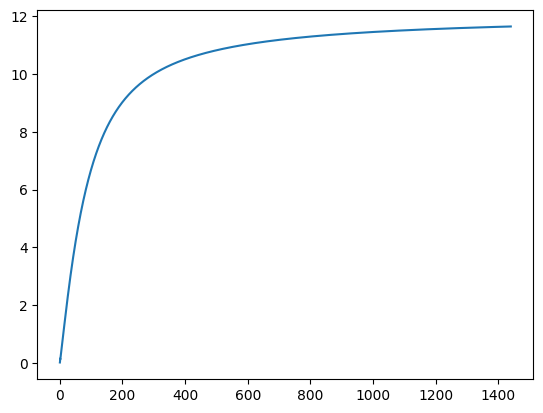

In [59]:
Q=data['humanHG_RBC']['solution']
lut=Q['lut']
fy1=Q['sol'][:,lut['redBloodCells']]
fy=Q['sol'][:,lut['plasma']]
qy=fy1[1:]/fy[1:]
t=Q['t']
matplotlib.pyplot.plot(t[1:],qy)

In [ ]:

pmodel=cModel.model()

model.parse(modelFile,parameterFile)
print('w(oI) {}'.format(model.getWeight('oralIngestion')))
t,sol,se,sOut,qt,lut,lutSE,setup1=runSolver.loadSolutionFromDir(humanHG)
compartment='kidney'
#compartment='liverI'
d=model.getDerivatives(sOut,lut[compartment])
w=model.getWeights(lutSE)
w=numpy.ones((len(lutSE)))
print('Sum ({}, der, sigma_p)'.format(compartment))
s={x:d[lutSE[x]]*w[lutSE[x]] for x in lutSE}
s=dict(sorted(s.items(), key=lambda item:item[1],reverse=True))
for p in list(s)[:10]:
    j=lutSE[p]
    print('\t{:.2g} [{:.2g} {:.2g}] {} '.format(d[j]*w[j],d[j],w[j],p))

In [23]:
model=getModel(data,'humanHGplusI_RBC')
tscale=runSolver.getScale(data['humanHGplusI_RBC']['solution']['setup'])
#calculate total mass of xeno-substance
model.get("bloodToPlasmaPCscale")
model.get("bloodVolume")


modelFile: /home/studen/temp/humanHGplusI_RBC/model.json True
parameterFile: /home/studen/temp/humanHGplusI_RBC/parameters.json True


{'value': 4.33728,
 'derivatives': {'plasmaTotalVolumeFraction': 67.77,
  'redBloodCellsVolumeFraction': 67.77,
  'bodyWeight': 0.064}}

In [40]:
getSum(data,'humanHGplusI_RBC')
tscale=runSolver.getScale(Q['setup'])
#calculate total mass of xeno-substance
model.get("bloodToPlasmaPCscale")
model.get("bloodVolume")

modelFile: /home/studen/temp/humanHGplusI_RBC/model.json True
parameterFile: /home/studen/temp/humanHGplusI_RBC/parameters.json True
0
1
2
3
5
6
7
9
10
11
12
13
15
16
17
19
0.999999998652029
[('brainI', 5.591268564730524e-08), ('urine', 6.920503851883565e-07), ('hairI', 2.829112820729282e-06), ('hair', 2.5908112965118847e-05), ('bloodI', 6.48014370354082e-05), ('kidneyI', 0.00034539782696188444), ('brainBlood', 0.0008838108138251085), ('fecesI', 0.0009365878956040508), ('liverI', 0.0016857155746677485), ('plasma', 0.002537491433132075), ('venous', 0.0025444401202051573), ('brain', 0.004082574560654416), ('kidney', 0.010365728769627663), ('gut', 0.013662463918991298), ('fat', 0.0257916393847429), ('feces', 0.02667203433643526), ('redBloodCells', 0.03545009717387017), ('richlyPerfused', 0.0636064259191453), ('liver', 0.09840624607901789), ('intestine', 0.30824288460368277), ('slowlyPerfused', 0.40469217361557336)]


{'value': 4.33728,
 'derivatives': {'plasmaTotalVolumeFraction': 67.77,
  'redBloodCellsVolumeFraction': 67.77,
  'bodyWeight': 0.064}}